In [1]:
import flymovie as fm
import numpy as np
import scipy.ndimage as ndi
from importlib import reload
from flymovie.general_functions import extract_box, stack_normalize_minmax

%load_ext autoreload
%autoreload 2

In [2]:
def loadfiles(files):
    stacklist = []
    for file in files:
        stack = fm.read_czi(file, swapaxes=False)
    
        if stack.ndim == 3:
            stacklist.append(stack)

        else:
            # Remove last frame
            stack = stack[:-1]
            for frame in stack:
                stacklist.append(frame)

    return stacklist

In [ ]:
filelist = [
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead2-01.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead3-02.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead3-03.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead4-02.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead5-02.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead6-01.czi',
    '/Volumes/stad3/2022-05-12/tetraspeck-green-solution-100x50x50-bead7-01.czi'
]

stacklist = loadfiles(filelist)

In [3]:
filelist = [
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em2-inguts-bead1-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em2-inguts-bead2-02.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em2-inguts-bead3-02.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em2-inguts-bead4-02.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead1-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead2-02.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead3-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead4-02.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead5-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em3-inguts-bead6-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em5-inguts-bead1-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em5-inguts-bead2-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em5-inguts-bead3-01.czi',
    '/Volumes/stad3/2022-05-19/tetraspeck-green-100x50x50-em5-inguts-bead4-01.czi'
]

stacklist = loadfiles(filelist)

In [4]:
len(stacklist)

72

In [10]:
boxes = fm.extract_beads_batch(stacklist, 3000, (27, 25, 25))

In [11]:
boxes.shape

(79, 27, 25, 25)

In [12]:
fm.viewer([boxes.max(axis=(1)) * 1000, boxes.max(axis=(2)) * 1000], 4)

interactive(children=(Dropdown(description='Color', index=10, options=('viridis', 'gray_r', 'gray', 'Gators', …

In [13]:
bad_beads = []
bad_beads=[5,7,12,13,14,15,16,17,18,19,20,31,36,38,39]

In [14]:
boxes_good = fm.remove_bad_beads(boxes, bad_beads)
psf = boxes_good.mean(axis=0)
fm.viewer([psf.max(axis=0) * 1000, psf.max(axis=1) * 1000, psf.max(axis=2) * 1000], 5)

interactive(children=(Dropdown(description='Color', index=10, options=('viridis', 'gray_r', 'gray', 'Gators', …

### Save original

In [24]:
psf_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220614_insitu_nm100x50x50_px27x25x25.pkl'
psf_to_save = psf[:,:,:]
fm.save_pickle(psf_to_save, psf_file)

### Stretch and save

In [ ]:
stretch_factor = 3
stretched = ndi.zoom(psf, (stretch_factor, 1, 1))
# Squeeze a little if desired to reduce kernel size.
stretched = stretched[22:-22, 2:-2, 2:-2]
stretched = stretched / np.max(stretched)
fm.viewer([psf.max(axis=1) * 1000, stretched.max(axis=1) * 1000], 5)

In [ ]:
stretched.shape

In [ ]:
stretched_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220503_100nmx50x50_79pxx21x21_zstretch3.0.pkl'
fm.save_pickle(stretched, stretched_file)

### Stretch lobes

In [ ]:
psf.shape

In [ ]:
def stretch_lobes(kernel, nslices, stretch_factor):
    top = kernel[:nslices]
    bottom = kernel[-nslices:]
    middle = kernel[nslices:-nslices]
    top = ndi.zoom(top, (stretch_factor,1,1))
    bottom = ndi.zoom(bottom, (stretch_factor,1,1))
    stretched = np.vstack((top, middle, bottom))
    return stretched

stretched = stretch_lobes(psf, 17, 2.2)
stretched.shape
#stretched = stretched[36:-36, 2:-2, 2:-2]
stretched = stretched[14:-14, :, :]
fm.viewer([psf.max(axis=0) * 1000, psf.max(axis=1) * 1000, stretched.max(axis=0) * 1000, stretched.max(axis=1) * 1000], 5)

In [ ]:
stretched.shape

In [ ]:
# Save lobe stretched PSF.
lobestretched_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220511_100nmx50x50_53pxx31x31_lobestretch_17_2.2.pkl'
fm.save_pickle(stretched, lobestretched_file)

### Fit and stretch

In [ ]:
def make_kernel(x, shape):
    """Make kernel of certain shape from fitted 3d gaussian function."""
    x1 = list(x.copy())
    x1[0] = int(shape[0] / 2)
    x1[1] = int(shape[1] / 2)
    x1[2] = int(shape[2] / 2)
    g = fm.gaussian3d(*x1)
    return g(*np.indices(shape))

In [ ]:
shape = (51,20,20)
opt = fm.fitgaussian3d(psf / np.max(psf))
x = opt.x.copy()
kernel_f = make_kernel(x, shape)

In [ ]:
fm.viewer(kernel_f.max(axis=1) * 1000, 5)

In [ ]:
# See current z-width.
original_zwidth = x[4]
print(original_zwidth)

In [ ]:
stretch_factor = 1.5
x[4] = stretch_factor * original_zwidth
shape = (51,20,20)
fitted = make_kernel(x, shape)
fm.viewer(fitted.max(axis=1) * 1000, 5)

In [ ]:
fitted_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/fitted_20220503_z4.2_100nmx50x50_51pxx20x20.pkl'
fm.save_pickle(fitted, fitted_file)

0.8474101533217263

In [20]:
s = (psf - np.min(psf)) / (np.max(psf) - np.min(psf))
b = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220519_mountingmedia_nm100x50x50_px27x25x25.pkl')

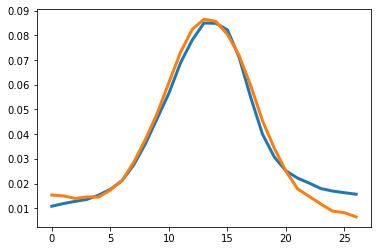

In [40]:
import matplotlib.pyplot as plt
a = 2
c=12
plt.plot(b.mean(axis=a)[:,c]/ b.mean(axis=a)[:,c].sum(), linewidth=3)
plt.plot(s.mean(axis=a)[:,c]/ s.mean(axis=a)[:,c].sum(), linewidth=3)